*Copyright (C) 2022 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Three Factor Learning with Lava 

**Motivation**: This tutorial demonstrates how Lava users can define and implement three factor learning rules using a software model of Loihi's learning engine.

#### This tutorial assumes that you:
- have the [Lava framework installed](../../in_depth/tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")
- are familiar with [Process interfaces in Lava](../../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- are familiar with [ProcessModel implementations in Lava](../../in_depth/tutorial02_process_models.ipynb "Tutorial on ProcessModels")
- are familiar with how to [connect Lava Processes](../../in_depth/tutorial05_connect_processes.ipynb "Tutorial on connecting Processes")
- are familiar with how to [implement a custom learning rule](../../in_depth/tutorial08_stdp.ipynb "Tutorial on STDP")

This tutorial demonstrates how the improved Lava Learning API can be used for simulation of three-factor learning rules. We first define a high-level interface for reward-modulated spike-timing dependent plasticity (R-STDP) rules in the Lava Process Library. We then execute a simulation of a spiking neural network in which localized, graded reward factors are mapped to specific plastic synapses, demonstrating Lava support for this new Loihi-2 learning capability. Finally, we demonstrate how users can define their own custom, three-factor learning rule interfaces and implement custom post-synaptic trace dynamics in simulation, as supported on Loihi-2 through microcoded post-synaptic neuron instructions. With these capabilities, Lava now provides support for many of the latest neuro-inspired learning algorithms under study!

### Defining three-factor learning rule interfaces in Lava

The Lava learning API can be used to represent a wide range of local learning rules that obey Loihi's sum-of-product learning rule form. Users can define define custom, reusable learning rule interfaces atop the full Lava learning engine equation parser. Here, we define a reusable interface for reward-modulated spike-timing dependent plasticity (R-STDP) that is now part of the standard Lava Process Library.

#### Reward-modulated Spike-Timing Dependent Plasticity (R-STDP) learning rule

Reward-modulated STDP is a three-factor learning rule that can explain how behaviourly relevant adaptive changes in a complex network of spiking neurons could be achieved in a self-organizing manner through local synaptic plasticity. A third, reward signal modulates the outcome of the pairwise two-factor learning rule STDP. The implementation of the R-STDP described below is adapted from [Neuromodulated Spike-Timing-Dependent Plasticity](https://www.frontiersin.org/articles/10.3389/fncir.2015.00085/full "Neuromodulated Spike-Timing-Dependent Plasticity, and Theory of Three-Factor Learning Rules").

Synaptic weights, $W$, are modulated as a function of the eligibility trace $E$ and reward term $R$:

$$\dot{W} = R \cdot E$$

The synaptic eligibility trace stores a temporary memory of the STDP outcome that persists through the epoch when a delayed reward signal is received. Defining the learning window of a traditional Hebbian STDP as $STDP(pre, post)$, where "pre" represents the pre-synaptic activity of a synapse and "post" represents the state of the post-synaptic neuron, the synaptic eligibility trace dynamics have the form:

$$\dot{E} = - \frac{E}{\tau_e} + STDP(pre, post)$$

#### The Lava R-STDP interface

The R-STDP dynamics described above can be re-defined using terms understood by Loihi's sum-of-product form learning engine. The eligibility trace $E$ can be stored in the tag variable $t$ of the Loihi learning engine. Tag dynamics $dt$ evolve according to 

$$dt = STDP(pre, post) - t \cdot \tau_{tag} \cdot u_0$$

where $\tau_{tag}$ is the time constant of the tag evolution. As described in the [STDP tutorial](../../in_depth/tutorial08_stdp.ipynb "Tutorial on STDP"), pairwise STDP dynamics $STDP(pre, post)$ can be re-defined using Loihi learning engine variables as

$$dt = ( A_{+} \cdot x_0 \cdot y_1 + A_{-} \cdot y_0 \cdot x_1 ) - t \cdot \tau_{tag} \cdot u_0$$

where $x_1$ and $y_1$ are the pre and postsynaptic spikes, $x_0$ and $y_0$ describe a rule execution dependence on the timing of the pre and postsynaptic spikes, respectively, and the spike timing behavior is scaled by the constants $A_{+} < 0$ and $A_{-} > 0$.

Weight evolution during learning $dw$ is a function of the tag dynamics $t$ and the reward signal, stored in Loihi's post-synaptic trace variable $y_2$:

$$dw = u_0 \cdot t \cdot y_2$$

$u_0$ is the Loihi learning engine's way of defining that the weight update occurs at every learning epoch.

NOTE: The values for learning-related parameters are adapted from online implemention of [Spike-Timing Dependent Plasticity (STDP)](http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity "Spike-Timing Dependent Plasticity") and can vary based on implementation. 

In [53]:
# INITIALIZING LEARNING-RELATED PARAMETERS
from lava.magma.core.learning.learning_rule import LoihiLearningRule

# Learning rule coefficient
A_plus = -2
A_minus = 2

learning_rate = 1

# Trace decay constants
x1_tau = 10
y1_tau = 10

# Eligibility trace decay constant
tag_tau = "2 ^ -1" 

# High reward decay constant for negligible decay
y2_tau = 2 ** 32-1

# Impulses
x1_impulse = 16
y1_impulse = 16

# Zero impulse value for reward. 
y2_impulse = 0

# Epoch length
t_epoch = 2

# String learning rule for dt : eligibility trace represented as t
dt = f"{learning_rate} * ({A_plus}) * x0 * y1 +" \
     f"{learning_rate} * {A_minus} * y0 * x1 - t * {tag_tau} * u0"

# String learning rule for dw
dw = " u0 * t * y2"

# Create custom LearningRule
R_STDP = LoihiLearningRule(dw=dw,
                           dt=dt,
                         x1_impulse=x1_impulse,
                         x1_tau=x1_tau,
                         y1_impulse=y1_impulse,
                         y1_tau=y1_tau,
                         y2_impulse=y2_impulse,
                         y2_tau=y2_tau,
                         t_epoch=t_epoch)

### Network Parameters and Spike Inputs

We now define the parameters of the network and generate frozen and random input spikes that act as inputs to the pre and post-synaptic neurons. We also generate graded reward spikes that are used to set the third-factor in the post-synaptic neuron. 

In [54]:
import numpy as np

# Set this tag to "fixed_pt" or "floating_pt" to choose the corresponding models.
SELECT_TAG = "floating_pt"

# LIF parameters : Only supports floating_pt for now. 
if SELECT_TAG == "floating_pt":
    du = 1
    dv = 1

vth = 240

# Number of pre-synaptic neurons per layer
num_neurons_pre = 1
shape_lif_pre = (num_neurons_pre, )
shape_conn_pre = (num_neurons_pre, num_neurons_pre)

# Number of post-synaptic neurons per layer
num_neurons_post = 2
shape_lif_post = (num_neurons_post, )
shape_conn_post = (num_neurons_post, num_neurons_pre)

# Connection parameters

# SpikePattern -> LIF connection weight : PRE-synaptic
wgt_inp_pre = np.eye(num_neurons_pre) * 250

# SpikePattern -> LIF connection weight : POST-synaptic
wgt_inp_post = np.eye(num_neurons_post) * 250

# Graded SpikePattern -> LIF connection weight : REWARD
wgt_inp_reward = np.eye(num_neurons_post) * 100

# LIF -> LIF connection initial weight (learning-enabled)
wgt_plast_conn = np.full(shape_conn_post, 50)
    
# Number of simulation time steps
num_steps = 200
time = list(range(1, num_steps + 1))

# Spike times
spike_prob = 0.03

# Create random spike rasters
np.random.seed(156)
spike_raster_pre = np.zeros((num_neurons_pre, num_steps))
np.place(spike_raster_pre, np.random.rand(num_neurons_pre, num_steps) < spike_prob, 1)

spike_raster_post = np.zeros((num_neurons_post, num_steps))
np.place(spike_raster_post, np.random.rand(num_neurons_post, num_steps) < spike_prob, 1)

# Create graded reward spikes
graded_reward_spikes = np.zeros((num_neurons_post, num_steps)) 
for index in range(num_steps):
    if index in range(100, 125):
        graded_reward_spikes[0][index] = 20
    if index in range(150, 175):
        graded_reward_spikes[1][index] = 20

### Create Network
The following diagram depicts the Lava Process architecture used in this tutorial. It consists of:
- 2 Constant pattern generators (Ring Buffer) for injecting spike trains to LIF neurons.
- 1 Constant pattern generator (Ring Buffer) for injecting graded reward spike train into the post-synaptic LIF neuron.
- 1 _LIF_ Process representing the pre-synaptic LIF neuron.
- 1 _LearningLIF_ Process representing two post-synaptic LIF neurons that calculate and update the third factor trace. 
- 1 _LearningDense_ Process representing learning-enabled connection between LIF neurons.

![R_STDP_architecture](r_stdp_tutorial_architecture.svg)

In [55]:
from lava.proc.lif.process import LIF, LearningLIF
from lava.proc.io.source import RingBuffer as SpikeIn
from lava.proc.dense.process import LearningDense, Dense 

In [56]:
# Create input devices
pattern_pre = SpikeIn(data=spike_raster_pre.astype(int))
pattern_post = SpikeIn(data=spike_raster_post.astype(int))

# Create graded reward input device
reward_pattern_post = SpikeIn(data=graded_reward_spikes.astype(float))

# Create input connectivity
conn_inp_pre = Dense(weights=wgt_inp_pre)
conn_inp_post = Dense(weights=wgt_inp_post)
conn_inp_reward = Dense(weights=wgt_inp_reward, num_message_bits=5)

# Create pre-synaptic neurons
lif_pre = LIF(u=0,
              v=0,
              du=du,
              dv=du,
              bias_mant=0,
              bias_exp=0,
              vth=vth,
              shape=shape_lif_pre,
              name='lif_pre')

# Create plastic connection
plast_conn = LearningDense(weights=wgt_plast_conn,
                   learning_rule=R_STDP,
                   name='plastic_dense')

# Create post-synaptic neuron
lif_post = LearningLIF(u=0,
               v=0,
               du=du,
               dv=du,
               bias_mant=0,
               bias_exp=0,
               vth=vth,
               shape=shape_lif_post,
               name='lif_post')

# Connect network
pattern_pre.s_out.connect(conn_inp_pre.s_in)
conn_inp_pre.a_out.connect(lif_pre.a_in)

pattern_post.s_out.connect(conn_inp_post.s_in)
conn_inp_post.a_out.connect(lif_post.a_in)

# Reward ports
reward_pattern_post.s_out.connect(conn_inp_reward.s_in)
conn_inp_reward.a_out.connect(lif_post.a_graded_reward_in)

lif_pre.s_out.connect(plast_conn.s_in)
plast_conn.a_out.connect(lif_post.a_in)

# Connect back-propagating action potential (BAP)
lif_post.s_out_bap.connect(plast_conn.s_in_bap)

# Connect reward trace callback (y2)
lif_post.s_out_y2.connect(plast_conn.s_in_y2)


### Create monitors to observe traces

Monitors are initialized to record and observe the state of the traces along with weight and tag dynamics. 

In [57]:
from lava.proc.monitor.process import Monitor

# Create monitors
mon_pre_trace = Monitor()
mon_post_trace = Monitor()
mon_reward_trace = Monitor()
mon_pre_spikes = Monitor()
mon_post_spikes = Monitor()
mon_weight = Monitor()
mon_tag = Monitor()
mon_s_in_y2 = Monitor()
mon_y2 = Monitor()

# Connect monitors
mon_pre_trace.probe(plast_conn.x1, num_steps)
mon_post_trace.probe(plast_conn.y1, num_steps)
mon_reward_trace.probe(lif_post.s_out_y2, num_steps)
mon_pre_spikes.probe(lif_pre.s_out, num_steps)
mon_post_spikes.probe(lif_post.s_out, num_steps)
mon_weight.probe(plast_conn.weights, num_steps)
mon_tag.probe(plast_conn.tag_1, num_steps)

### Running the Lava Process Archicture to Simulate R-STDP

The spiking neural network is simulated for 200 time steps using the Loihi2 simulation configuration. 

In [58]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg

In [59]:
# Running
pattern_pre.run(condition=RunSteps(num_steps=num_steps), run_cfg=Loihi2SimCfg(select_tag=SELECT_TAG))

In [60]:
# Get data from monitors
pre_trace = mon_pre_trace.get_data()['plastic_dense']['x1']
post_trace = mon_post_trace.get_data()['plastic_dense']['y1']
reward_trace = mon_reward_trace.get_data()['lif_post']['s_out_y2']
pre_spikes = mon_pre_spikes.get_data()['lif_pre']['s_out']
post_spikes = mon_post_spikes.get_data()['lif_post']['s_out']
weights_neuron_A = mon_weight.get_data()['plastic_dense']['weights'][:, 0, 0]
weights_neuron_B = mon_weight.get_data()['plastic_dense']['weights'][:, 1, 0]
tag_neuron_A = mon_tag.get_data()['plastic_dense']['tag_1'][:, 0, 0]
tag_neuron_B = mon_tag.get_data()['plastic_dense']['tag_1'][:, 1, 0]

In [61]:
# Stopping
pattern_pre.stop()

### Results and Visualization

We plot the pre and post-synaptic spikes and results of the simulation. First, we visualize the pre- and post-synaptic spikes trains that shows the spike times of the input spikes. For reference, the two post-synaptic neurons are named as post-synaptic neuron A and post-synaptic neuron B. 

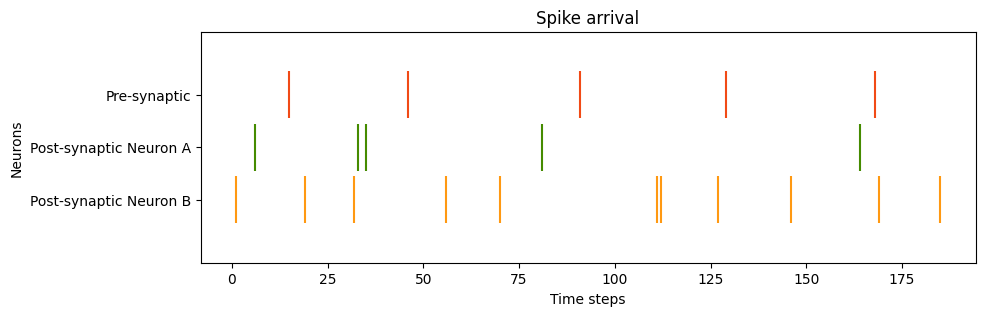

In [62]:
import matplotlib.pyplot as plt

# Plotting pre- and post- spike arrival
def plot_spikes(spikes, legend, colors):
    offsets = list(range(1, len(spikes) + 1))
    
    plt.figure(figsize=(10, 3))
    
    spikes_plot = plt.eventplot(positions=spikes, 
                                lineoffsets=offsets,
                                linelength=0.9,
                                colors=colors)
    
    plt.title("Spike arrival")
    plt.xlabel("Time steps")
    plt.ylabel("Neurons")
    plt.yticks(ticks=offsets, labels=legend)
    
    plt.show()

# Plot spikes
plot_spikes(spikes=[np.where(post_spikes[:, 1])[0], np.where(post_spikes[:, 0])[0], np.where(pre_spikes[:, 0])[0]], 
            legend=['Post-synaptic Neuron B', 'Post-synaptic Neuron A', 'Pre-synaptic'], 
            colors=['#ff9912', 	'#458b00',  '#f14a16'])

##### Plotting Pre-synaptic and Post-synaptic Trace Dynamics
The pre- and post-synaptic spike trace dynamics describes the integration of the spike input's across time. The plots below shows how the traces evolve with respect to the spike input. At the onset of the pre-synaptic spike the pre-synaptic trace value $x_1$ is increased by a magnitude of 'x1_impulse' and decay's slowly at 'x1_tau' decrements until the next spike. This behaviour can be observed in the plot shown below. The same process is applied for the post-synaptic traces also.  

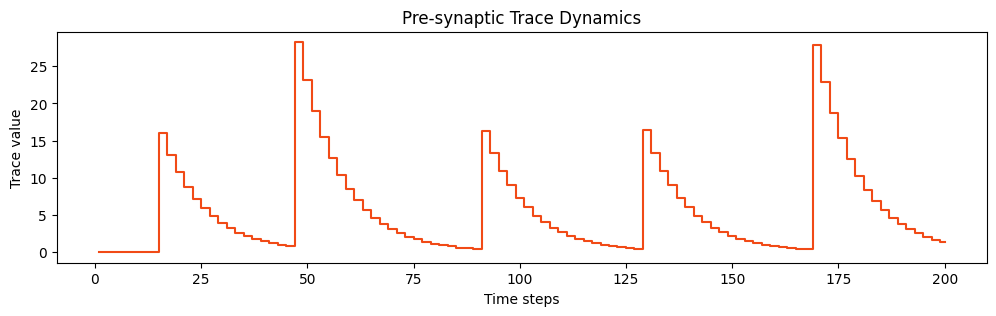

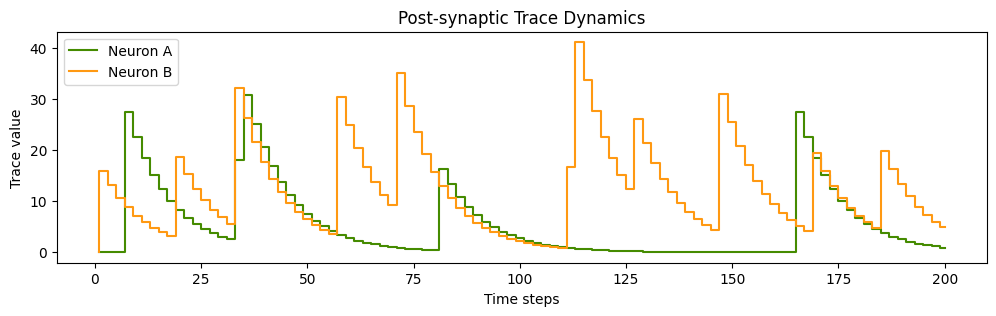

In [63]:
# Plotting trace dynamics
    
def plot_time_series(time, time_series, ylabel, title, figsize, color):
    plt.figure(figsize=figsize)
    
    plt.step(time, time_series, color=color)
    
    
    plt.title(title)
    plt.xlabel("Time steps")
    plt.ylabel(ylabel)
    
    plt.show()

def plot_time_series_subplots(time, time_series_y1, time_series_y2, ylabel, title, figsize, color, legend):    
    plt.figure(figsize=figsize)
    
    plt.step(time, time_series_y1, label=legend[0], color=color[0])
    plt.step(time, time_series_y2, label=legend[1], color=color[1])
        
    plt.title(title)
    plt.xlabel("Time steps")
    plt.ylabel(ylabel)
    plt.legend(loc="upper left")
    
    plt.show()
    
# Plotting pre trace dynamics
plot_time_series(time=time, time_series=pre_trace, ylabel="Trace value", title="Pre-synaptic Trace Dynamics", figsize=(12, 3), color='#f14a16')

# Plotting post trace dynamics
time = time
time_series_y1 = post_trace[:, 0]
time_series_y2 = post_trace[:, 1]
ylabel = "Trace value"
title = "Post-synaptic Trace Dynamics"
figsize = (12, 3)
color = ['#458b00', '#ff9912']
legend = ['Neuron A', 'Neuron B']

plot_time_series_subplots(time=time, time_series_y1=time_series_y1, time_series_y2=time_series_y2, ylabel=ylabel, title=title, figsize=figsize, color=color, legend=legend)

##### Third Factor Trace

The reward trace, which is fed in as an input to both the post-synaptic neurons, is considered as the third factor trace. In Loihi2, the magnitude and timing of the post-synaptic reward traces can be driven heterogenously by synaptic inputs and can vary across neurons. This functionality is showcased by driving the two post-synaptic neurons with reward traces that have a temporally differing graded impulse traces. The plot below show's the third factor reward trace that is sent to the _LearningDense_ process which updates the plastic synapse accordingly.

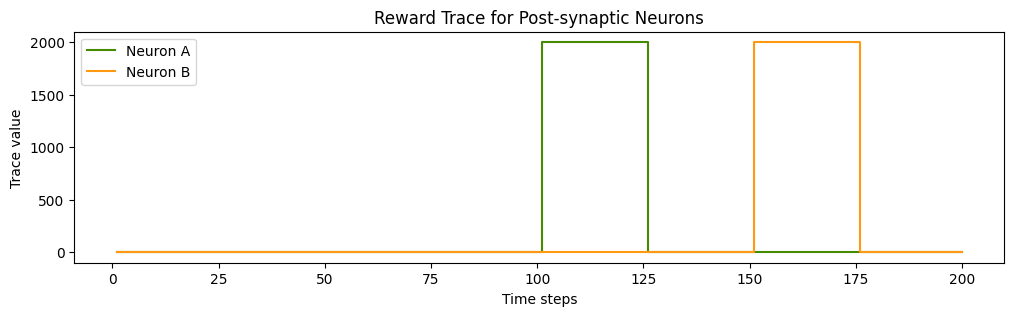

In [64]:
# Plotting reward trace dynamics
time = time
time_series_y1 = reward_trace[:, 0]
time_series_y2 = reward_trace[:, 1]
ylabel = "Trace value"
title = "Reward Trace for Post-synaptic Neurons"
figsize = (12, 3)
color = ['#458b00', '#ff9912']
legend = ['Neuron A', 'Neuron B']

plot_time_series_subplots(time=time, time_series_y1=time_series_y1, time_series_y2=time_series_y2, ylabel=ylabel, title=title, figsize=figsize, color=color, legend=legend)

##### Weight (dw) and Tag (dt) Dynamics

The trace dynamics of the tag $dt$ and the weight $dw$ variables show the learning of the plastic synapse based on the R-STDP learning rule. The plot below shows magnitude of the traces across time steps.

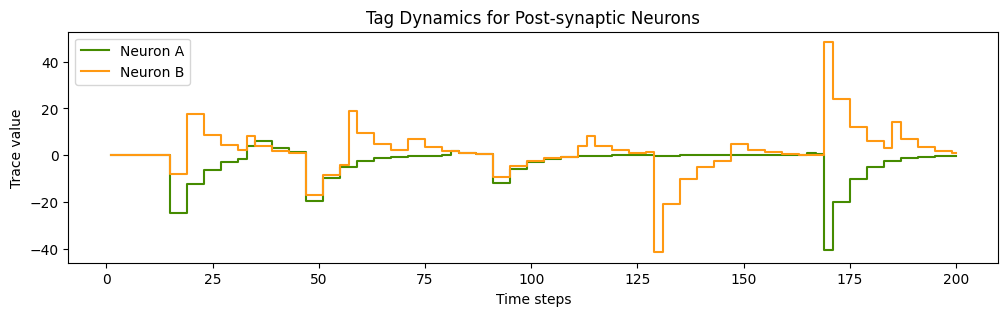

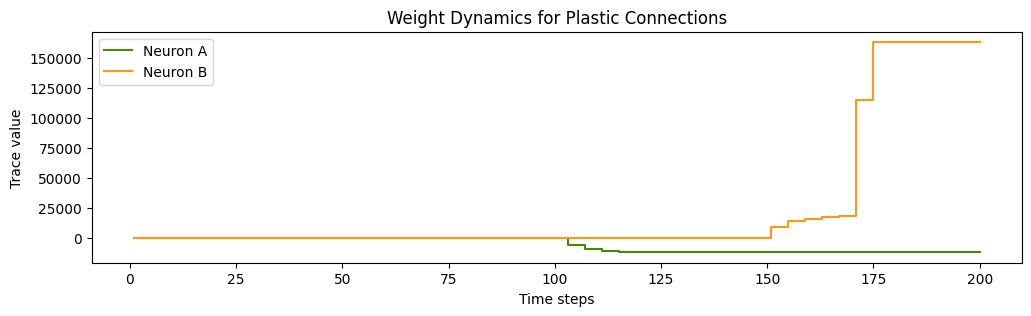

In [65]:
# Plotting tag dynamics
time = time
time_series_y1 = tag_neuron_A
time_series_y2 = tag_neuron_B
ylabel = "Trace value"
title = "Tag Dynamics for Post-synaptic Neurons"
figsize = (12, 3)
color = ['#458b00', '#ff9912']
legend = ['Neuron A', 'Neuron B']

plot_time_series_subplots(time=time, time_series_y1=time_series_y1, time_series_y2=time_series_y2, ylabel=ylabel, title=title, figsize=figsize, color=color, legend=legend)

# Plotting weight dynamics 
time = time
time_series_y1 = weights_neuron_A
time_series_y2 = weights_neuron_B
ylabel = "Trace value"
title = "Weight Dynamics for Plastic Connections"
figsize = (12, 3)
color = ['#458b00', '#ff9912']
legend = ['Neuron A', 'Neuron B']

plot_time_series_subplots(time=time, time_series_y1=time_series_y1, time_series_y2=time_series_y2, ylabel=ylabel, title=title, figsize=figsize, color=color, legend=legend)

### How to learn more?

#### Follow the links below for deep-dive tutorials on the concepts in this tutorial:
- [Processes](../../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- [ProcessModel](../../in_depth/tutorial03_process_models.ipynb "Tutorial on ProcessModels")
- [Execution](../../in_depth/tutorial04_execution.ipynb "Tutorial on Executing Processes")
- [Connecting Processes](../../in_depth/tutorial05_connect_processes.ipynb "Tutorial on connecting Processes")

If you want to find out more about Lava, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava/ "Lava Source Code").

To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").